In [2]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import keras
from keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split



/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Get data and insights

In [3]:
ground_truth_file = ('ISIC2018_Task3_Training_GroundTruth.csv')
images_dir = ('ISIC2018_Task3_Training_Input')
df = pd.read_csv(ground_truth_file)
print(df.head())
print(df.columns)
print("number of cols ", len(df))
print (df.head())

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')
number of cols  10015
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


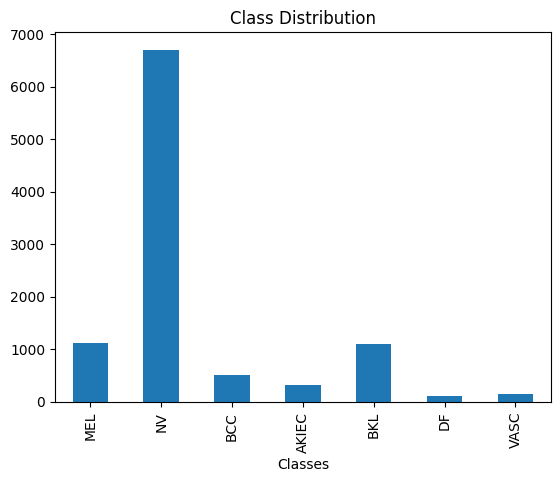

In [4]:
plt.figure()
# skip the first because its just the images, sum them as they are one hot encoded, 
# iloc makes you access rows and columns of a DataFrame based on their index positions, just like you would in a regular array 
df.iloc[:, 1:].sum().plot(kind='bar') 
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.show()


In [5]:
def show_imgs(df, n=10):
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i in range(n):
        img_path = os.path.join('ISIC2018_Task3_Training_Input', df.iloc[i, 0] + '.jpg')
        img = Image.open(img_path)
        axes[i].imshow(img)
        label = df.iloc[i, 1:].idxmax()
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

#show_imgs(df)


## Prepare data

In [10]:
# takes around x
def load_data(df, img_path, img_size):
    images = []
    labels = []

    for i in range(len(df)):
        img_path = os.path.join(images_dir, df.iloc[i, 0] + '.jpg')
        img = Image.open(img_path).resize(img_size)
        img = np.array(img)

        # learned from TA that we should normalize the images
        img = img / 255.0

        images.append(img)
        labels.append(df.iloc[i, 1:].values)
        if i == 100:
            break

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

images, labels = load_data(df, ground_truth_file, (600, 450)) # all 600x400





print(f"Image data shape: {images.shape}")
print(f"Label data shape: {labels.shape}")
        

Image data shape: (101, 450, 600, 3)
Label data shape: (101, 7)


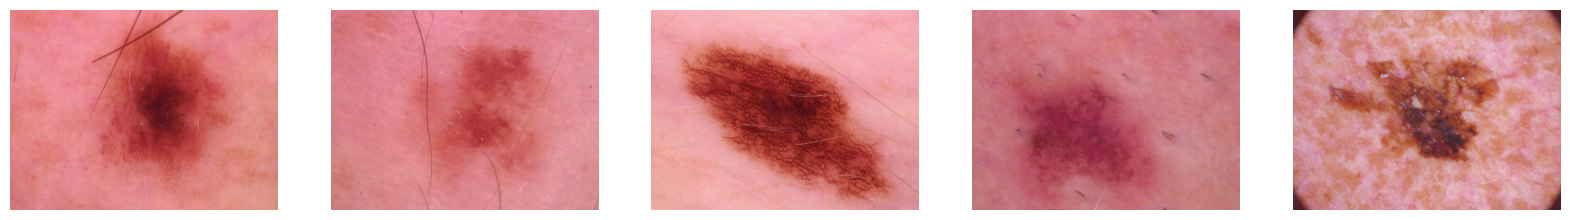

In [11]:
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()



In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

# its already one-hot encoded, so no need to do that
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")

Training set shape: (8012, 224, 224, 3), (8012, 7)
Validation set shape: (2003, 224, 224, 3), (2003, 7)


## First softmax regression

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation

keras.utils.set_random_seed(0)

input_shape = (224, 224, 3)
num_classes = 7


# Model
model = Sequential()
model.add(Flatten(input_shape=input_shape)) 
model.add(Dense(num_classes)) # num_classes is 7
model.add(Activation('softmax'))

model.summary()


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     1,053,703 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,703 (4.02 MB)

 Trainable params: 1,053,703 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 128
epochs = 30

# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

# Fit model
history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_val, y_val))

score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.4487 - loss: 130.6331 - val_accuracy: 0.3335 - val_loss: 103.9394
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.5026 - loss: 117.5160 - val_accuracy: 0.6680 - val_loss: 194.8421
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.5378 - loss: 105.9989 - val_accuracy: 0.6560 - val_loss: 70.5786
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.5306 - loss: 83.9525 - val_accuracy: 0.2811 - val_loss: 74.6991
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.5211 - loss: 82.4475 - val_accuracy: 0.3470 - val_loss: 72.8654
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - accuracy: 0.5317 - loss: 83.2277 - val_accuracy: 0.6016 - val_loss: 27.5619
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.5313 - loss: 78.1732 - val_accuracy: 0.6680 - val_loss: 181.5732
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.5396 - los

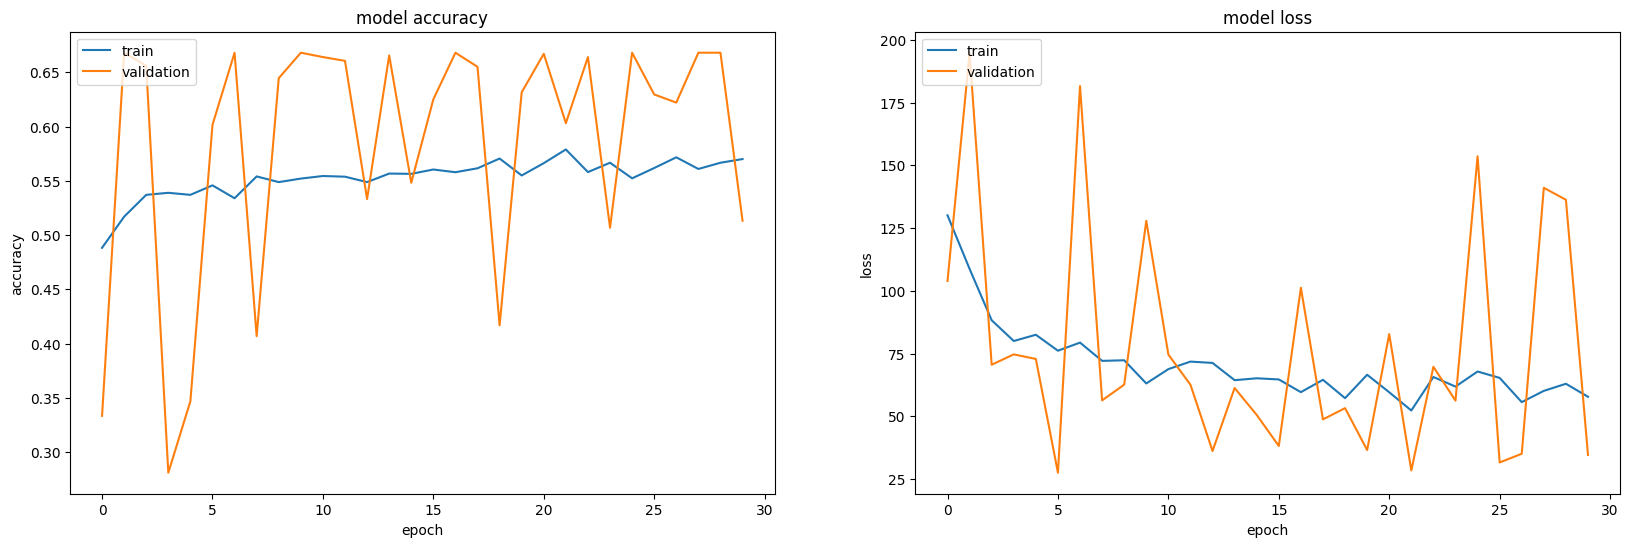

In [12]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


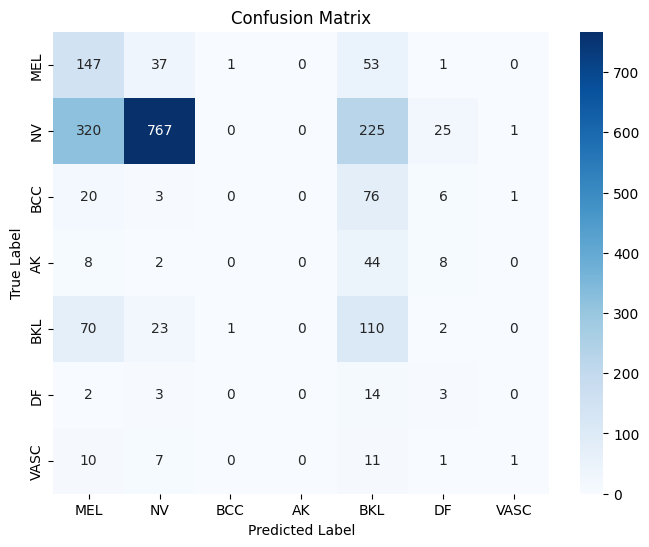

In [13]:
# Assuming you have already trained your model
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix():

    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

    y_pred = model.predict(X_val)

    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = np.argmax(y_val, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # 5. Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
show_confusion_matrix()


## CNN

In [14]:
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input
from keras.models import Model

keras.utils.set_random_seed(0)

inputs = Input(shape=(224, 224, 3))

# Encoder (convolutional base)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(units=64, activation='relu')(encoded)
x = Dropout(rate=0.5)(x)
predictions = Dense(units=num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,544,343 (21.15 MB)

 Trainable params: 5,544,343 (21.15 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_val, y_val))

score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Valdiation accuracy:', score[1])

Epoch 1/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - accuracy: 0.6495 - loss: 1.3618 - val_accuracy: 0.6680 - val_loss: 1.1363
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.6644 - loss: 1.1433 - val_accuracy: 0.6680 - val_loss: 1.1355
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.6644 - loss: 1.1416 - val_accuracy: 0.6680 - val_loss: 1.1351
Epoch 4/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.6644 - loss: 1.1412 - val_accuracy: 0.6680 - val_loss: 1.1351
Epoch 5/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6644 - loss: 1.1405 - val_accuracy: 0.6680 - val_loss: 1.1349
Epoch 6/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6644 - loss: 1.1409 - val_accuracy: 0.6680 - val_loss: 1.1350
Epoch 7/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.6644 - loss: 1.1407 - val_accuracy: 0.6680 - val_loss: 1.1348
Epoch 8/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 46s 57ms/step - accuracy: 0.6644 - loss: 1.1404 - 

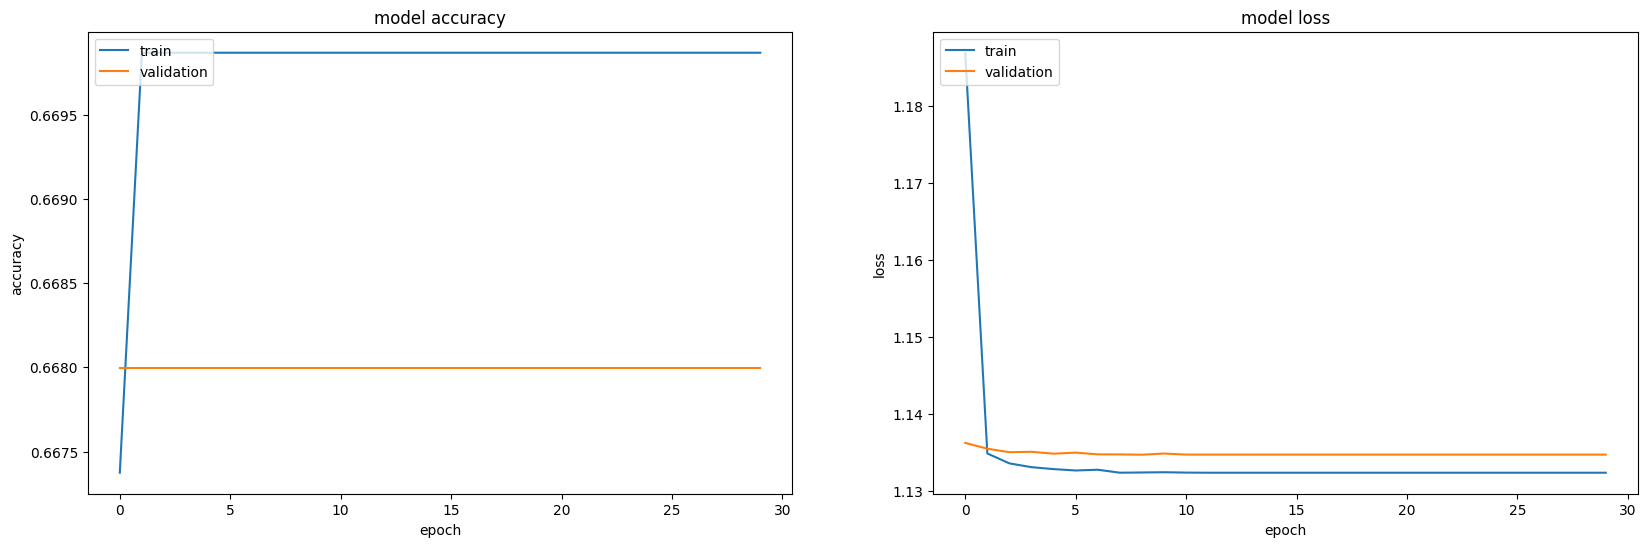

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


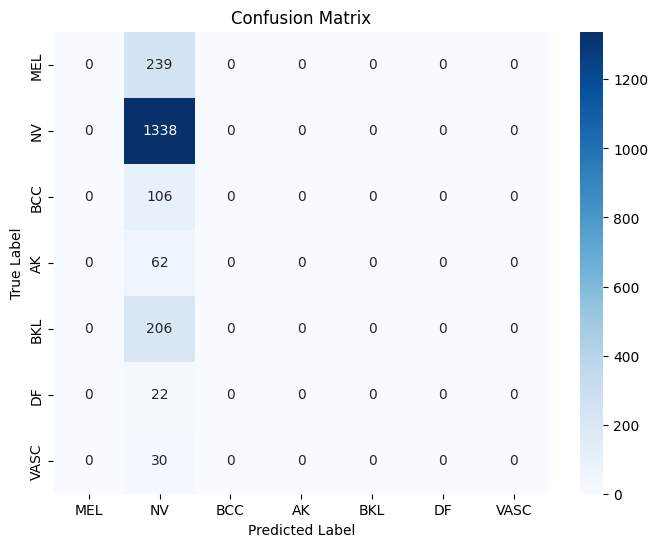

In [16]:
show_history(history)
show_confusion_matrix()

Take aways are: Data is heavily weighted towards NV so no matter how we design the model its just going to guess NV. However, CNN seems to perform better than simple softmax regression. If we use 24 pixels it tries to predict other things than NV - but with 224 it can make the more informed decision to just guess NV alle the time

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def show_confusion_matrix(model, generator):
    # Retrieve class names from the generator
    class_names = list(generator.class_indices.keys())

    # Initialize lists to collect predictions and true labels
    y_pred = []
    y_true = []

    # Generate predictions and collect true labels for each batch
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        y_pred_batch = model.predict(X_batch)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))

    # Create the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()







In [4]:
train_dir = "Data Set Ordered/training data/"
val_dir = "Data Set Ordered/validation data/"
test_dir = "Data Set Ordered/test data/"

from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
)


# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

# Validation generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
)

Found 10015 images belonging to 7 classes.
Found 193 images belonging to 7 classes.
Found 1512 images belonging to 7 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


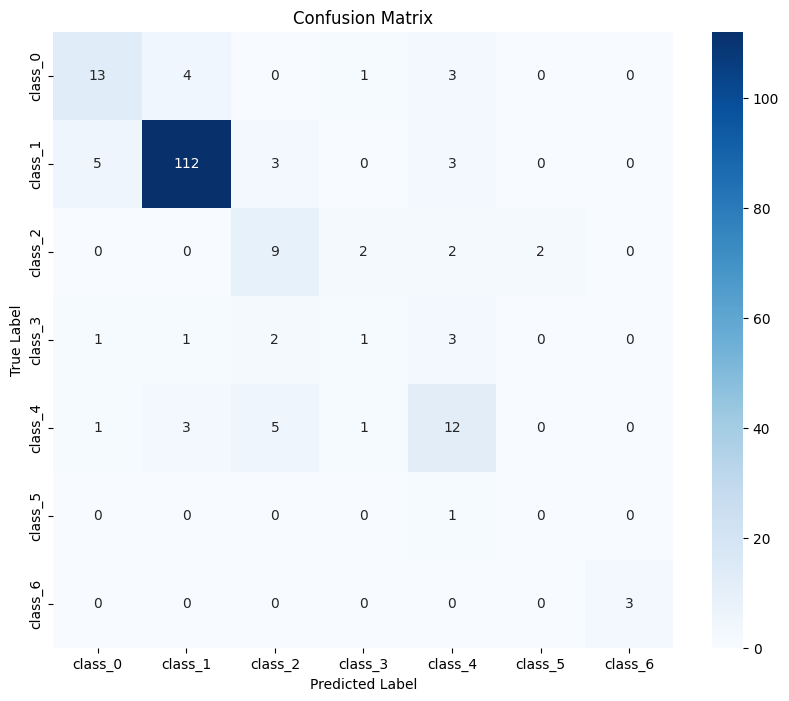

In [7]:
from tensorflow.keras.models import load_model
#show_all_plots(history2, load_model("models/best_model1"), val_dataloader)
model = load_model("models/best_model1.keras")
show_confusion_matrix(model, validation_generator)

In [8]:
results = model.evaluate(test_generator)

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.7129 - loss: 4.7205
